---
title: Working with pyCATHY and DA
subtitle: PART1 - DA and ERT assimilation
license: CC-BY-4.0
github: https://github.com/BenjMy/ETH_pyCATHY/
subject: Tutorial
authors:
  - name: Benjamin Mary
    email: benjamin.mary@ica.csic.es
    corresponding: true
    orcid: 0000-0001-7199-2885
    affiliations:
      - ICA-CSIC
date: 2024/04/12
---

```{toc} Table of Contents
:depth: 3
```

In [1]:
import pyCATHY
from pyCATHY import cathy_tools
from pyCATHY.ERT import petro_Archie as Archie
from pyCATHY.importers import cathy_inputs as in_CT
import pyCATHY.meshtools as cathy_meshtools
from pyCATHY.DA.cathy_DA import DA, dictObs_2pd
from pyCATHY.DA.observations import read_observations, prepare_observations, make_data_cov
from pyCATHY.DA.perturbate import perturbate_parm
from pyCATHY.DA import perturbate

import utils

In [2]:
import pygimli as pg
from pygimli.physics import ert
import pygimli.meshtools as mt

In [3]:
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib as mpl
# set some default plotting parameters for nicer looking plots
mpl.rcParams.update({"axes.grid":True, 
                     "grid.color":"gray", 
                     "grid.linestyle":'--',
                     'figure.figsize':(10,10)}
                   )
import pandas as pd

The notebooks does **not** describe: 
- **Preprocessing step**: build a mesh, inputs preparations, ...

The notebooks describe: 

Create [synthetic soil moisture content dataset](#fwd_mod_sol) and add [noise](#add_noise_SMC). 

1. [**Prepare for Data Assimilation**](prep_DA)
   - 2.1 Read observations
   - 2.1.2 Create covariance matrices
   - 2.2 Perturbate
   - 2.3 Define mapping operator
   
2. **Simulation**: [solve the surface-subsurface flow](#solve).

In [4]:
# Create a CATHY project
# -----------------------
simu_solution = cathy_tools.CATHY(
                                    dirName='./solution_ERT',
                                    prj_name= 'weill_dataset',
                                    notebook=True,
                                  )
simu_solution.workdir

🏁 Initiate CATHY object

'/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./solution_ERT'

### Set ERT data error estimate

In [5]:
#pts_data_err = 1e99 # This correspond to the simulation "withoutDA"
pts_data_err = 10 # absolute error
prjName = 'Weill_example_withDA' # without DA means that the level of noise set to data covariance is infinite (open loop run); 
#prjName = 'Weill_example_withoutDA' # without DA means that the level of noise set to data covariance is infinite (open loop run); 


```{caution}
    Project names: 
    
      - "without DA" means that the level of noise set to the observed data is infinite (1e99) (open loop run)
        See the [import SMC section](#import_SMC_obs)
      - "with DA" with a noise level according to sensors uncertainties
      
    Choose and comment the simulation you need to run!
```

In [6]:
# Create a CATHY project
# -----------------------
simuWithDA = DA(
                        dirName='./DA_ERT',
                        prj_name= prjName,
                        #prj_name= 'Weill_example_withDA', 
                        notebook=True,
                    )

simuWithDA.run_preprocessor()
simuWithDA.run_processor(IPRT1=3)

🏁 Initiate CATHY object

🍳 gfortran compilation

👟 Run preprocessor

🔄 update parm file 

🔄 Update hap.in file

🔄 update dem_parameters file 

🔄 update dem_parameters file 

🛠  Recompile src files [3s]

🍳 gfortran compilation [7s]

b''

👟 Run processor

In [7]:
netValue = -1e-7
rain = 4e-7
tatmbc = list(np.linspace(0,86400,10))

netValue_list = [netValue]*len(tatmbc)
netValue_list[0] = netValue + rain
netValue_list[1] = netValue + rain

simuWithDA.update_atmbc(
                        HSPATM=1,
                        IETO=0,
                        time=tatmbc,
                        # VALUE=[None, None],
                        netValue=netValue_list,
                )

simuWithDA.update_parm(TIMPRTi=tatmbc)
simuWithDA.update_soil(PMIN=-1e25)



🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

['Adjusting NPRT with respect to time of interests requested\n']

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 Update soil

homogeneous soil

In [8]:
meshCiPG_PGref = pv.read('../solution_ERT/meshCi.vtk')
meshLiPG_PGref = pv.read('../solution_ERT/meshLi.vtk')

yshift = 8
xshift = 8


(meshCiPG, meshLiPG) = utils.define_mesh_transformations(meshCiPG_PGref,
                                                          meshLiPG_PGref,
                                                          idC=yshift, 
                                                          idL=xshift,
                                                        )

# In[12]:


pt1, _ = simu_solution.find_nearest_node([0,yshift,meshLiPG.points[:,2].max()])
pt2, _ = simu_solution.find_nearest_node([5,yshift,meshLiPG.points[:,2].max()])
pt3, _ = simu_solution.find_nearest_node([10,yshift,meshLiPG.points[:,2].max()])


pt1, _ = simu_solution.find_nearest_node([xshift,0,meshLiPG.points[:,2].max()])
pt2, _ = simu_solution.find_nearest_node([xshift,5,meshLiPG.points[:,2].max()])
pt3, _ = simu_solution.find_nearest_node([xshift,10,meshLiPG.points[:,2].max()])



pl = pv.Plotter(notebook=False)
mesh = pv.read(os.path.join(simu_solution.workdir,
                                simu_solution.project_name,
                                'vtk/100.vtk',
                               )
       )
pl.add_mesh(mesh,
           opacity=0.2
           )
# pl.add_mesh(meshCiPG,
#               color='red'
#               )
pl.add_points(mesh.points[pt1],
              color='red',
              render_points_as_spheres=True,
              point_size=10
              )

pl.add_points(mesh.points[pt2],
              color='red',
              render_points_as_spheres=True,
              point_size=10
              )

pl.add_points(mesh.points[pt3],
              color='red',
              render_points_as_spheres=True,
              point_size=10
              )

pl.add_mesh(meshLiPG,
              color='b'
              )
pl.show_grid()
pl.show()

nodeIds = [pt1,pt2,pt3]

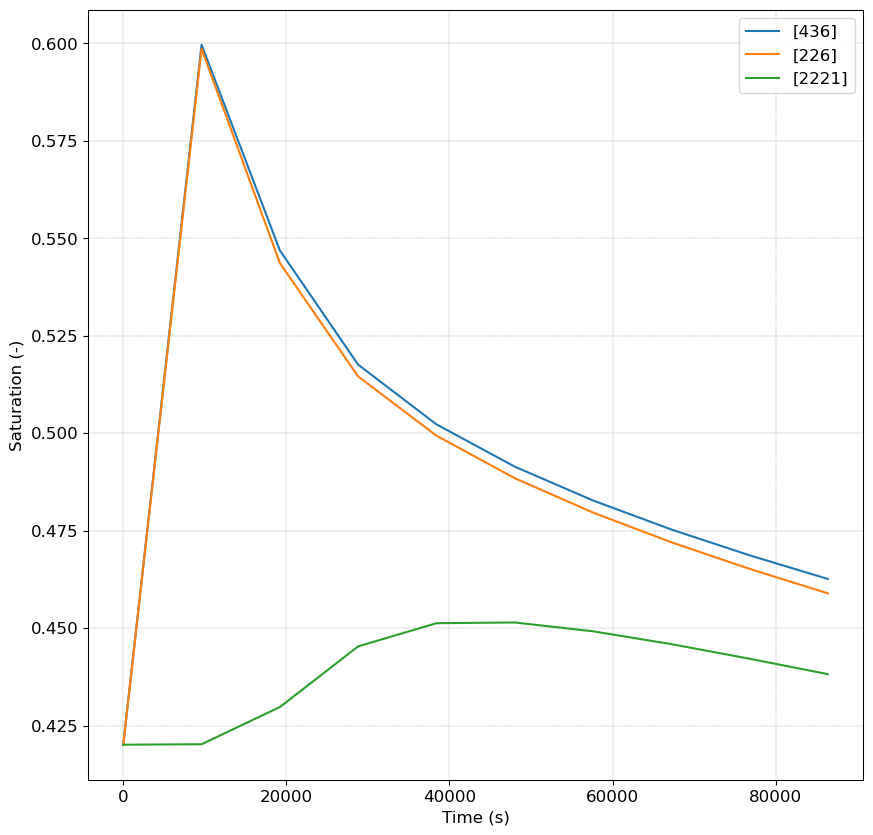

In [9]:
df_sw, sw_times = simu_solution.read_outputs('sw')

fig, ax = plt.subplots()
for nn in nodeIds:
    ax.plot(df_sw.index,
            df_sw[nn],
            label=nn
            )
ax.set_xlabel('Time (s)')
ax.set_ylabel('Saturation (-)')
plt.legend()

In [10]:

SPP_df, FP_df =  simu_solution.read_inputs('soil',MAXVEG=1)
SPP_df.head()


# In[16]:

POROS = SPP_df['POROS'].mean()


# In[22]:


scenario = {
    
            # scenario without parameter update
            # -------------------------------------
            'ic_ZROOT_NOupdate': {'per_type': [None,None],
                                 'per_name':['ic', 'ZROOT'],
                                 'per_nom':[-1,0.4],
                                 'per_mean':[-1,0.4],    
                                 'per_sigma': [1.75,5e-3],
                                 'per_bounds': [None,{'min':0,'max':1.5}],
                                 'sampling_type': ['normal']*2,
                                 'transf_type':[None,None],
                                'listUpdateParm': ['St. var.'],
                                },
    
            # scenario with parameter update
            # -------------------------------------
            'ic_ZROOT_upd_ZROOT': 
                                                        {'per_type': [None,None], 
                                                         'per_name':['ic', 'ZROOT'],
                                                         'per_nom':[-1,0.4],
                                                         'per_mean':[-1,0.4],    
                                                         'per_sigma': [1.75,5e-3],
                                                         'per_bounds': [None,{'min':0,'max':1.5}],
                                                         'sampling_type': ['normal']*2,
                                                         'transf_type':[None,None],
                                                         'listUpdateParm': ['St. var.', 'ZROOT']
                                                         },    
            }
print(scenario)



{'ic_ZROOT_NOupdate': {'per_type': [None, None], 'per_name': ['ic', 'ZROOT'], 'per_nom': [-1, 0.4], 'per_mean': [-1, 0.4], 'per_sigma': [1.75, 0.005], 'per_bounds': [None, {'min': 0, 'max': 1.5}], 'sampling_type': ['normal', 'normal'], 'transf_type': [None, None], 'listUpdateParm': ['St. var.']}, 'ic_ZROOT_upd_ZROOT': {'per_type': [None, None], 'per_name': ['ic', 'ZROOT'], 'per_nom': [-1, 0.4], 'per_mean': [-1, 0.4], 'per_sigma': [1.75, 0.005], 'per_bounds': [None, {'min': 0, 'max': 1.5}], 'sampling_type': ['normal', 'normal'], 'transf_type': [None, None], 'listUpdateParm': ['St. var.', 'ZROOT']}}


In [11]:

#%%
# Define mapping operator
# ----------------------
# rFluid_Archie = 1/(infitration_log_selec['water_EC_(microS/cm)']*(1e-6/1e-2))
print('Unknown fluid conductivity')
rFluid_Archie = 1/(588*(1e-6/1e-2))
rFluid_Archie
simuWithDA.set_Archie_parm(
                            rFluid_Archie=[rFluid_Archie],
                            a_Archie=[0.3],
                            m_Archie=[1.7],
                            n_Archie=[1.7],
                            pert_sigma_Archie=[0],
                            )


Unknown fluid conductivity


In [12]:
# Round elements in ERT_times to the nearest hundred ! this is a bug in the simulation
sw_times_rounded = [round(swt, -2) for swt in sw_times]
common_elements = sorted(set(sw_times_rounded) & set(tatmbc))
indices_sw_times = [sw_times_rounded.index(element) for element in common_elements]
sw_times_common_rounded = [sw_times_rounded[idx] for idx in indices_sw_times]

In [13]:

dict_obs = {} # initiate the dictionnary

# ERT observations metadata
# -------------------------
metadata_ERT    = {
                    'data_type': '$ERT$', # units
                    'units': '$\Ohm$', # units transfer_resistances
                    'forward_mesh_vtk_file': '../solution_ERT/meshLi.vtk', # path to the ERT mesh (vtk file compatible with pygimli or resipy)
                    # 'sequenceERT': sequenceERT, # path to the ERT sequence  (file compatible with pygimli or resipy)
                    # 'instrument': 'Syscal', # Instrument
                    'data_format': 'pygimli', # format (raw or preprocessed)
                    'dataErr': pts_data_err, # error in %
                    'fwdNoiseLevel': 5, # error in %
                    'mesh_nodes_modif': meshLiPG.points, 
        
                }

# sw_times_common_rounded.insert(0,0)

for i, tt in enumerate(sw_times_common_rounded):

    # if i == 1:
    #     pass
    
    # .data file observation generated by pygimli
    filename = os.path.join(simu_solution.workdir,
                            'ERTsolution', 
                            'ERT_Li_' + str(i) + '.data'
                            )
    
    data_measure = read_observations(
                                    dict_obs,
                                    filename, 
                                    data_type = 'ERT', 
                                    data_err = metadata_ERT['dataErr'], # instrumental error
                                    show=True,
                                    tA=tt,
                                    obs_cov_type='data_err', #data_err
                                    # elecs=elecs,
                                    meta=metadata_ERT,
                                    # datetime=ERT_datetimes[i]
                                    ) # data_err  reciprocal_err
    
data_measure_df = dictObs_2pd(dict_obs) 
data_measure_df.head()


data_format  \
sensorNameidx assimilation time               
ERT           0.0                   pygimli   
              9600.0                pygimli   
              19200.0               pygimli   
              28800.0               pygimli   
              38400.0               pygimli   

                                                                       sequenceERT  \
sensorNameidx assimilation time                                                      
ERT           0.0                /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCS...   
              9600.0             /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCS...   
              19200.0            /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCS...   
              28800.0            /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCS...   
              38400.0            /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCS...   

                                                                             elecs  \
sensorNameidx assimilation time                                                      
ERT           0.0                [[0.0, 0.0, 0.0], [0.5, 0.0, 0.0], [1.0, 0.0, ...   
              9600.0             [[0.0, 0.0, 0.0], [0.5, 0.0, 0.0], [1.0, 0.0, ...   
              19200.0            [[0.0, 0.0, 0.0], [0.5, 0.0, 0.0], [1.0, 0.0, ...   
              28800.0            [[0.0, 0.0, 0.0], [0.5, 0.0, 0.0], [1.0, 0.0, ...   
              38400.0            [[0.0, 0.0, 0.0], [0.5, 0.0, 0.0], [1.0, 0.0, ...   

                                 fwdNoiseLevel  \
sensorNameidx assimilation time                  
ERT           0.0                            5   
              9600.0                         5   
              19200.0                        5   
              28800.0                        5   
              38400.0                        5   

                                                                          filename  \
sensorNameidx assimilation time                                                      
ERT           0.0                /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCS...   
              9600.0             /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCS...   
              19200.0            /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCS...   
              28800.0            /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCS...   
              38400.0            /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCS...   

                                data_type   units  \
sensorNameidx assimilation time                     
ERT           0.0                   $ERT$  $\Ohm$   
              9600.0                $ERT$  $\Ohm$   
              19200.0               $ERT$  $\Ohm$   
              28800.0               $ERT$  $\Ohm$   
              38400.0               $ERT$  $\Ohm$   

                                                                              data  \
sensorNameidx assimilation time                                                      
ERT           0.0                     a  b   m   n             k    r       rho...   
              9600.0                  a  b   m   n             k    r       rho...   
              19200.0                 a  b   m   n             k    r       rho...   
              28800.0                 a  b   m   n             k    r       rho...   
              38400.0                 a  b   m   n             k    r       rho...   

                                 data_err mesh_nodes  assimilation_times  \
sensorNameidx assimilation time                                            
ERT           0.0                      10         []                 0.0   
              9600.0                   10         []              9600.0   
              19200.0                  10         []             19200.0   
              28800.0                  10         []             28800.0   
              38400.0                  10         []             38400.0   

                                da

In [14]:
data_cov, data_pert, stacked_data_cov = make_data_cov(
                                                        simuWithDA,
                                                        dict_obs,
                                                        list_assimilated_obs = 'all',
                                                        nb_assimilation_times=len(dict_obs)
                                                        )

simuWithDA.stacked_data_cov = stacked_data_cov

ERT
ERT
ERT
ERT
ERT
ERT
ERT
ERT
ERT
ERT


In [15]:
# simuWithDA.update_soil()

🔄 update parm file 

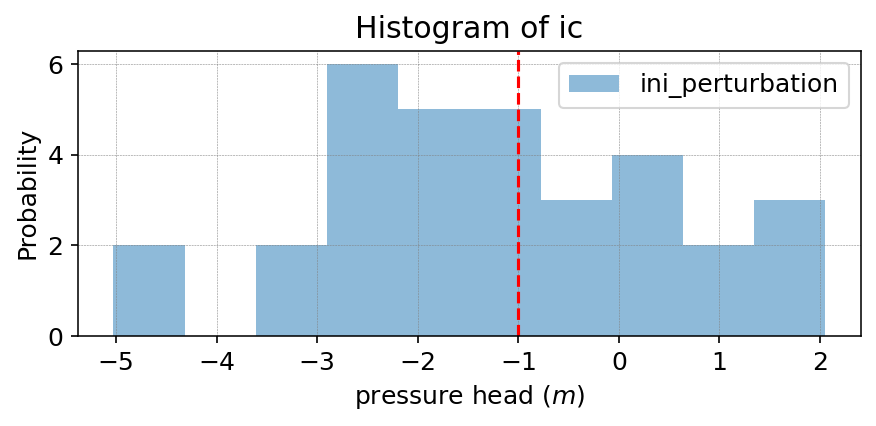

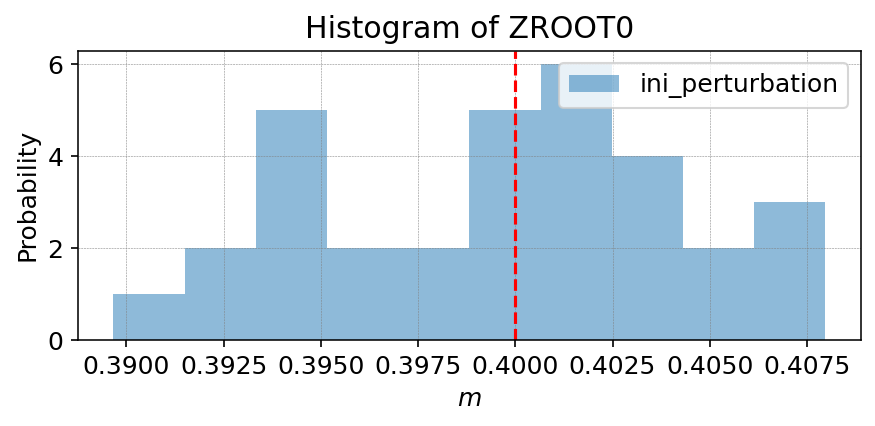

In [16]:

NENS = 32
list_pert = perturbate.perturbate(
                                    simuWithDA, 
                                    scenario['ic_ZROOT_NOupdate'], 
                                    NENS,
                                 )

var_per_dict_stacked = {}
for dp in list_pert:
    # need to call perturbate_var as many times as variable to perturbate
    # return a dict merging all variable perturbate to parse into prepare_DA
    var_per_dict_stacked = perturbate_parm(
                                var_per_dict_stacked,
                                parm=dp, 
                                type_parm = dp['type_parm'], # can also be VAN GENUCHTEN PARAMETERS
                                mean =  dp['mean'],
                                sd =  dp['sd'],
                                sampling_type =  dp['sampling_type'],
                                ensemble_size =  dp['ensemble_size'], # size of the ensemble
                                per_type= dp['per_type'],
                                savefig= os.path.join(simuWithDA.workdir,
                                                      simuWithDA.project_name,
                                                      simuWithDA.project_name + dp['savefig'])
                                )

simuWithDA.update_parm(
                        IPRT1=2,
                        TRAFLAG=0,
                        DTMIN=1e-2,DTMAX=1e3,DELTAT=1,
                        VTKF=2,
                        )



(solve)=
## Solve Data Assimilation Sequentially

In [17]:
simuWithDA.run_DA_sequential(
                              parallel=True,    
                              dict_obs= dict_obs,
                              list_assimilated_obs='all', # default
                              list_parm2update=scenario['ic_ZROOT_NOupdate']['listUpdateParm'],
                              DA_type='enkf_Evensen2009_Sakov',
                              dict_parm_pert=var_per_dict_stacked,
                              open_loop_run=False,
                              threshold_rejected=80,
                              # damping=1                   
                            )

🔄 update parm file 

🛠  Recompile src files [9s]

🍳 gfortran compilation [13s]

b''

😟 processor exe not found

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

VGN parameters not defined - Falling back to defaults

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 Update ensemble

🍳 gfortran compilation

👟 Run preprocessor

🔄 update parm file 

🛠  Recompile src files [17s]

🍳 gfortran compilation [21s]

b''

👟 Run processor

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

homogeneous soil

🧽 update input ensemble

🔄 update parm file 

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

['Adjusting NPRT with respect to time of interests requested\n']

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

👟 Run hydrological model

✅ check scenarii before analysis

❌ df_mbeconv['time']0.02, ens_nb:5

❌ df_mbeconv['time']0.0725, ens_nb:15

cannot read mbeconv


❌ df_mbeconv['time']0.0725, ens_nb:22

❌ df_mbeconv['time']0.025625, ens_nb:23

❌ df_mbeconv['time']0.025625, ens_nb:25

⚡ Mapping to ERT prediction

                                    Fwd modelling ERT
                                    Noise level: {??}
                                    

────────────────────────────────────────── 🐙 Parameter perturbation 🐙 ───────────────────────────────────────────

                                    Archie perturbation for DA analysis
                                    Archie rFluid: [17.006802721088437]
                                    Pert. Sigma Archie: [0]
                                    Nb of zones (?): 1
                                    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted0.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted0.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted0.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted0.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted0.vtk

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted0.vtkmin 56.396235949866245, max 56.396235949866245, median 72.400

fwd ER data



end of CATHY_2_pg
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted0_nearIntrp2_pg_msh.vtk
add new attribute to pg meshadd new attribute to pg meshfwd ERT Noise Level: 5

fwd ER data

fwd ER data


fwd ERT Noise Level: 5fwd ERT Noise Level: 5

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted0_nearIntrp2_pg_msh.vtkmin 57.19239016197272, max 57.19239016197272, median 73.58501419250447 
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted0_nearIntrp2_pg_msh.vtk

fwd ER data





/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted0_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5end of CATHY_2_pgadd new attribute to pg meshend of CATHY_2_pgmin 14.09702131816752, max 14.09702131816752, median 14.097021318167526 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_19/vtk/ER_converted0_nearIntrp2_pg_msh.vtkend of CATHY_2_pg
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted0_nearIntrp2_pg_msh.vtk


add new attribute to pg mesh





end of CATHY_2_pg
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_7/vtk/ER_converted0_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY

fwd ER data

fwd ER data

add new attribute to pg meshmin 39.9013525047367, max 39.9013525047367, median 48.00071481343085 
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted0_nearIntrp2_pg_msh.vtkend of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_24/vtk/ER_converted0_nearIntrp2_pg_msh.vtk


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted0_nearIntrp2_pg_msh.vtk



fwd ER data

fwd ERT Noise Level: 5

end of CATHY_2_pg


end of CATHY_2_pg
end of CATHY_2_pg
fwd ERT Noise Level: 5add new attribute to pg meshend of CATHY_2_pg

fwd ER data

fwd ER data

fwd ERT Noise Level: 5end of CATHY_2_pg
end of CATHY_2_pg

end of CATHY_2_pg

fwd ERT Noise Level: 5fwd ERT Noise Level: 5

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted0_nearIntrp2_pg_msh.vtk




fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted0_nearIntrp2_pg_msh.vtk

fwd ER data

fwd ERT Noise Level: 5

fwd ER data

fwd ER data


fwd ERT Noise Level: 5


fwd ER data

fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted0_nearIntrp2_pg_msh.vtk
fwd ERT Noise Level: 5

fwd ER data

fwd ERT Noise Level: 5fwd ERT Noise Level: 5




fwd ERT Noise Level: 5end of CATHY_2_pg

fwd ER data


fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted0_nearIntrp2_pg_msh.vtk
fwd ERT Noise Level: 5

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_11/vtk/ER_converted0_nearIntrp2_pg_msh.vtk

fwd ER data

end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_9/vtk/ER_converted0_nearIntrp2_pg_msh.vtk
fwd ERT Noise Level: 5


fwd ER data

fwd ERT Noise Level: 5
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5

end of CATHY_2_pgend of CATHY_2_pg



fwd ER data

fwd ERT Noise Level: 5

end of CATHY_2_pg


fwd ER data

fwd ER data

fwd ERT Noise Level: 5
fwd ERT Noise Level: 5


16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 3.0156265296488685 69.33637818573182


end of ER prediction

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 3.076506462775176 70.73625647778854


end of ER prediction

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 3.067017811802243 70.51807657653393
16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.6413856953472385 60.73059586890007


end of ER prediction

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.3609770917791333 54.28263464441973
16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 3.076706425939073 70.74084083638593
16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.6952451698037567 61.9691712688075
16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 1.1918410494872493 27.405795681825744
16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.9921416402754306 68.79639209018698
16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.9417883051652254 67.63853638109718


end of ER prediction

end of ER prediction

end of ER prediction

See eq. 4.4 thesis Isabelle p.95

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.6557497107001358 61.06091922888376


end of ER prediction

end of ER prediction

end of ER prediction

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.5351269569410917 58.287104207667795


end of ER prediction

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5916531263108697 13.62445177975436


end of ER prediction

end of ER prediction

end of ER prediction

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 3.3792612156247572 77.69740569189022


max res after Archie

29.026673163059286

end of ER prediction

See eq. 4.4 thesis Isabelle p.95

See eq. 4.4 thesis Isabelle p.95

max res after Archie

74.62218347043715

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_30/vtk/ER_converted0.vtk


16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 1.890397698542614 43.46505286167453


end of ER prediction

max res after Archie

min 24.058198977634323, max 24.058198977634323, median 24.1195713222614 


70.33190084397737


add new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_30/vtk/ER_converted0_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted0.vtk
min 57.888929468437375, max 57.888929468437375, median 74.62218347043715 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted0.vtk

add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted0_nearIntrp2_pg_msh.vtk
min 55.004068369040304, max 55.004068369040304, median 70.33190084397737 end of CATHY_2_pg

add new attribute to pg mesh


fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted0_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5


16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5916662030768799 13.624620413953368


end of ER prediction

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.8243540460587 64.93811081038828


end of ER prediction

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.9056546031532005 66.80763857311389


end of ER prediction

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.737121647459214 62.932144428201845
16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 3.332195535950976 76.61525661748152
16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.869614613273585 65.97889227382763


end of ER prediction

end of ER prediction

end of ER prediction

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5917136039887793 13.626818348322505


end of ER prediction

16/05/24 - 09:26:03 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.5792188141527905 59.301016562939246


end of ER prediction

16/05/24 - 09:26:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 1.0085195002057648 23.16122628088939


end of ER prediction

16/05/24 - 09:26:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.920813501941246 67.01906509150928
16/05/24 - 09:26:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 2.75621278681285 63.24339709857555


end of ER prediction

end of ER prediction

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (171,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

─────────────────────────────────────── 📍 end of time step (s) 0/86400 📍 ────────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 1/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 1/10 🔴 ───────────────────────────────────────────

───────────────────────────────────────── 🎯 % of valid ensemble: 81.25🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

⚡ Mapping to ERT prediction

                                    Fwd modelling ERT
                                    Noise level: {??}
                                    

────────────────────────────────────────── 🐙 Parameter perturbation 🐙 ───────────────────────────────────────────

                                    Archie perturbation for DA analysis
                                    Archie rFluid: [17.006802721088437]
                                    Pert. Sigma Archie: [0]
                                    Nb of zones (?): 1
                                    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted1.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted1.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted1.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_1/vtk/ER_converted1.vtk


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted1.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted1.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH

fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted1_nearIntrp2_pg_msh.vtk

add new attribute to pg meshfwd ERT Noise Level: 5min 105.52495851922346, max 105.52495851922346, median 126.10235714323497 add new attribute to pg mesh
min 14.09702131816752, max 14.09702131816752, median 14.097021318167526 
min 14.09702131816752, max 14.09702131816752, median 14.097021318167526 
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_1/vtk/ER_converted1_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted1.vtk
min 14.09702131816752, max 14.09702131816752, median 14.097021318167526 add new attribute to pg mesh
add new attribute to pg mesh

min 14.09702131816752, max 14.09702131816752, median 14.09702131

fwd ER data



min 14.09702131816752, max 14.09702131816752, median 14.097021318167526 fwd ERT Noise Level: 5
min 14.09702131816752, max 14.09702131816752, median 14.097021318167526 
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_9/vtk/ER_converted1.vtk


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted1_nearIntrp2_pg_msh.vtk


fwd ER data

add new attribute to pg mesh
add new attribute to pg meshmin 14.09702131816752, max 14.09702131816752, median 14.097021318167526 add new attribute to pg mesh

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted1_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted1_nearIntrp2_pg_msh.vtk

add new attribute to pg mesh

end of CATHY_2_pgadd new attribute to pg mesh
end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted1_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted1_nearIntrp2_pg_msh.vtkmin 106.18180898957615, max 106.18180898957615, 

fwd ER data

fwd ER data

fwd ER data


fwd ERT Noise Level: 5fwd ERT Noise Level: 5end of CATHY_2_pgmin 14.09702131816752, max 14.09702131816752, median 14.097021318167526 end of CATHY_2_pg



add new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_19/vtk/ER_converted1_nearIntrp2_pg_msh.vtk
fwd ERT Noise Level: 5

add new attribute to pg meshend of CATHY_2_pg

fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted1_nearIntrp2_pg_msh.vtk


fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted1_nearIntrp2_pg_msh.vtk

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted1_nearIntrp2_pg_msh.vtkend of CATHY_2_pg
end of CATHY_2_pg

fwd ER data

end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted1_nearIntrp2_pg_msh.vtk

fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_24/vtk/ER_converted1_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted1_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5end of CATHY_2_pg


end of CATHY_2_pgmin 14.09702131816752, max 14.09702131816752, median 14.097021318167526 





min 104.04635310832937, max 104.04635310832937, median 125.18111012346989 

fwd ER data

end of CATHY_2_pg
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_11/vtk/ER_converted1_nearIntrp2_pg_msh.vtk

fwd ER data



end of CATHY_2_pg

fwd ER data

fwd ER data

add new attribute to pg mesh


fwd ER data


fwd ERT Noise Level: 5fwd ERT Noise Level: 5add new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted1_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5

fwd ERT Noise Level: 5fwd ERT Noise Level: 5

fwd ER data

fwd ER data


end of CATHY_2_pg

fwd ERT Noise Level: 5end of CATHY_2_pgfwd ERT Noise Level: 5



fwd ER data


fwd ERT Noise Level: 5

fwd ER data



fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted1_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted1_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_9/vtk/ER_converted1_nearIntrp2_pg_msh.vtk

end of CATHY_2_pg


fwd ER data


fwd ERT Noise Level: 5
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5


end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_7/vtk/ER_converted1.vtk
min 106.17745942306533, max 106.17745942306533, median 126.45528279435698 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted1.vtk

add new attribute to pg meshmin 14.09702131816752, max 14.09702131816752, median 14.097021318167526 
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_7/vtk/ER_converted1_nearIntrp2_pg_msh.vtk

end of CATHY_2_pgadd new attribute to pg mesh


fwd ER data

fwd ERT Noise Level: 5

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted1_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5


16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5862285991164051 13.390620554639845


end of ER prediction

See eq. 4.4 thesis Isabelle p.95

max res after Archie

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5864803221324788 13.383734596767008


126.58165950917181

end of ER prediction

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_30/vtk/ER_converted1.vtk
min 105.75962333228098, max 105.75962333228098, median 126.23300677893852 
add new attribute to pg mesh

See eq. 4.4 thesis Isabelle p.95

max res after Archie

32.540202269283284


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_30/vtk/ER_converted1_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5939594865198773 13.684251563701254


fwd ERT Noise Level: 5


end of ER prediction

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5885142592086552 13.484815130020394


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted1.vtk

end of ER prediction


min 14.09702131816752, max 14.09702131816752, median 14.097021318167526 
add new attribute to pg mesh


16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5849432927019081 13.378027829796743
16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5847144540241683 13.368537204875677


See eq. 4.4 thesis Isabelle p.95

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted1_nearIntrp2_pg_msh.vtk

end of ER prediction

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5855535276069275 13.371226074617391
16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5853595603021374 13.386404867673404


end of ER prediction

end of CATHY_2_pg


fwd ER data

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 4.999344622587599 114.95430789116398


fwd ERT Noise Level: 5


16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5907650337698012 13.575745793203565
16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 4.816077222753004 110.72378135549593


end of ER prediction

end of ER prediction

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 4.983060002062626 114.57566865704646
16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5829049966959008 13.311835874682073


end of ER prediction

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 4.942058035288394 113.62596227926863


end of ER prediction

end of ER prediction

end of ER prediction

max res after Archie

32.8318556360324

end of ER prediction

end of ER prediction

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted1.vtk
min 14.09702131816752, max 14.09702131816752, median 14.097021318167526 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted1_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5


16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5903068233463662 13.564705429433827


end of ER prediction

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5850473596019887 13.348504089500267


end of ER prediction

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.585217900056329 13.3843561671012


end of ER prediction

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 4.999360421336975 114.95465631081366


end of ER prediction

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.592590275623055 13.642002714420379
16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5893135599831073 13.52223998220614


end of ER prediction

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5825660999514278 13.298378075828538


end of ER prediction

end of ER prediction

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 4.999314110139638 114.95359950216192


end of ER prediction

16/05/24 - 09:27:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5849302159371343 13.37769869707631


end of ER prediction

16/05/24 - 09:27:12 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.008869809756792 114.95617854832575


end of ER prediction

16/05/24 - 09:27:12 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5880589393126077 13.380203636692594


end of ER prediction

16/05/24 - 09:27:12 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.5905489798111245 13.466252890652138


end of ER prediction

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (171,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

!positive pressure heads observed!


✅ check scenarii post update

────────────────────────────────────── 📍 end of time step (s) 9600/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 2/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 2/10 🔴 ───────────────────────────────────────────

───────────────────────────────────────── 🎯 % of valid ensemble: 81.25🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

cannot read mbeconv
cannot read mbeconv
cannot read mbeconv
cannot read mbeconv
cannot read mbeconv
cannot read mbeconv
cannot read mbeconv


⚡ Mapping to ERT prediction

                                    Fwd modelling ERT
                                    Noise level: {??}
                                    

────────────────────────────────────────── 🐙 Parameter perturbation 🐙 ───────────────────────────────────────────

                                    Archie perturbation for DA analysis
                                    Archie rFluid: [17.006802721088437]
                                    Pert. Sigma Archie: [0]
                                    Nb of zones (?): 1
                                    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted2.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted2.vtk
min 127.70850224568035, max 127.70850224568035, median 128.3073839412067 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted2.vtk
min 127.70778183712115, max 127.70778183712115, median 128.30734991035104 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted2_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5
min 127.70835177724346, max 127.70835177724346, median 128.30738367178378 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted2_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted2_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted2.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted2.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted2.vtk

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted2.vtk
min 127.70728826641921, max 127.70728826641921, median 128.30730743879263 
add new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted2.vtk

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_

fwd ER data


fwd ERT Noise Level: 5
min 127.70838150865241, max 127.70838150865241, median 128.3073839412067 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted2.vtk
min 127.7082705436403, max 127.7082705436403, median 128.30736628662274 
min 127.70674988541789, max 127.70674988541789, median 128.3072816319833 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted2_nearIntrp2_pg_msh.vtkadd new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted2_nearIntrp2_pg_msh.vtk

add new attribute to pg mesh


add new attribute to pg meshmin 127.70849084530106, max 127.70849084530106, median 128.3073839412067 end of CATHY_2_pg
end of CATHY_2_pg
add new attribute to pg mesh


/home/z0272571a@CAMPUS.

fwd ER data

fwd ER data

fwd ERT Noise Level: 5
fwd ERT Noise Level: 5end of CATHY_2_pg


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted2.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted2.vtk

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted2.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted2.vtk

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted2_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted2.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted2_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted2_nearIn

fwd ER data

add new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted2.vtkfwd ERT Noise Level: 5


fwd ER data


fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted2.vtk

fwd ER data



fwd ERT Noise Level: 5

fwd ER data




fwd ERT Noise Level: 5
min 127.7082705436403, max 127.7082705436403, median 128.30736628662274 min 127.70718780756106, max 127.70718780756106, median 128.30730370840877 
add new attribute to pg mesh

add new attribute to pg mesh
min 127.70754614797143, max 127.70754614797143, median 128.30733870713755 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted2_nearIntrp2_pg_msh.vtkmin 127.7084121552915, max 127.7084121552915, median 128.3073839412067 
add new attribute to pg mesh

min 127.7084121552915, max 127.7084121552915, median 128.3073839412067 
min 127.70647337903766, max 127.70647337903766, median 128.30726499547967 add new attribute to pg meshadd new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted2_nearIntrp2_pg_msh.vtk



add new attribute to pg meshmin 127.707

fwd ER data


fwd ERT Noise Level: 5end of CATHY_2_pg

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted2_nearIntrp2_pg_msh.vtk


fwd ER data


end of CATHY_2_pgfwd ERT Noise Level: 5
end of CATHY_2_pg

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted2_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg

fwd ER data

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted2_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted2_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5
fwd ERT Noise Level: 5


end of CATHY_2_pg

fwd ER data


end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted2_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5


end of CATHY_2_pg

fwd ER data

fwd ER data

fwd ERT Noise Level: 5
fwd ERT Noise Level: 5



fwd ER data

fwd ERT Noise Level: 5


16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208409728589183 119.74410552456453


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2084080960571955 119.74409391820667


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208400466620485 119.74388062197171


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208403736379075 119.7439522518187


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2084031890719995 119.7439517966653


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208409185976727 119.74410728836469


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208407548750121 119.74405232853788


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208398286781423 119.74385627126485


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208402099152468 119.74392920965093
16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208408638669653 119.74410324885137


end of ER prediction

end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208408638669653 119.74410216783512


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208412455735317 119.744189045321
16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208409185976727 119.74409232516977


end of ER prediction

end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208408643364213 119.74405306818906


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208392289876691 119.74370948440111


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208408643364213 119.74405306818906
16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208408638669653 119.74409164243967


end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2084119084282445 119.74416867715254


end of ER prediction

end of ER prediction

16/05/24 - 09:28:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208395017022832 119.7437671181196


end of ER prediction

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (171,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 19200/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 3/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 3/10 🔴 ───────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 59.375🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

⚡ Mapping to ERT prediction

                                    Fwd modelling ERT
                                    Noise level: {??}
                                    

────────────────────────────────────────── 🐙 Parameter perturbation 🐙 ───────────────────────────────────────────

                                    Archie perturbation for DA analysis
                                    Archie rFluid: [17.006802721088437]
                                    Pert. Sigma Archie: [0]
                                    Nb of zones (?): 1
                                    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted3.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted3.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted3.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted3.vtk
min 127.707741751686, max 127.707741751686, median 128.30734991035104 

add new attribute to pg mesh
min 127.70844188533663, max 127.70844188533663, median 128.3073839412067 
add new attribute to pg mesh
min 127.70890040419137, max 127.70890040419137, median 128.30742373011375 min 127.70837190338791, max 127.70837190338791, median 128.3073839412067 

add new attribute to p

fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted3_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted3_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted3_nearIntrp2_pg_msh.vtk

end of CATHY_2_pgend of CATHY_2_pg



fwd ER data

fwd ER data

fwd ERT Noise Level: 5fwd ERT Noise Level: 5

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted3.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted3.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted3.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted3.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted3.vtk
min 127.70643223421102, max 127.70643223421102, median 128.30726499547967 
add new attribute to pg mesh
min 127.70835088179244, max 127.70835088179244, median 128.307383

fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted3_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5add new attribute to pg meshmin 127.70771114130132, max 127.70771114130132, median 128.30734991035104 


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted3.vtk
add new attribute to pg mesh
end of CATHY_2_pg



fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted3_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted3.vtkend of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted3.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted3.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted3.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted3.vtk/home

fwd ER data



/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted3.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted3_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted3.vtkadd new attribute to pg mesh
fwd ERT Noise Level: 5

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted3.vtk

fwd ERT Noise Level: 5


end of CATHY_2_pg



fwd ER data

fwd ERT Noise Level: 5
min 127.70831152729436, max 127.70831152729436, median 128.30738367178378 
add new attribute to pg mesh
min 127.70823118923927, max 127.70823118923927, median 128.30736628662274 
add new attribute to pg meshmin 127.70751552186796, max 127.70751552186796, median 128.30733870713755 
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted3_nearIntrp2_pg_msh.vtk
min 127.70823118923927, max 127.70823118923927, median 128.30736628662274 min 127.70714755908227, max 127.70714755908227, median 128.30730370840877 add new attribute to pg mesh

min 127.70725764054446, max 127.70725764054446, median 128.30730743879263 add new attribute to pg meshadd new attribute to pg mesh




end of CATHY_2_pgmin 127.70837190338791, max 127.70837190338791, median 128.3073839412067 add new attribute to pg mesh

min 127.70835177724346, max 127.70835177724346, median 128.3073839412067 

fwd ER data


min 127.70880936763581, max 127.70880936763581, median 128.3074190872251 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted3_nearIntrp2_pg_msh.vtk
fwd ERT Noise Level: 5

end of CATHY_2_pgadd new attribute to pg mesh

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted3_nearIntrp2_pg_msh.vtk


fwd ER data

add new attribute to pg mesh
fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted3_nearIntrp2_pg_msh.vtk

end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted3_nearIntrp2_pg_msh.vtk

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted3_nearIntrp2_pg_msh.vtk
end of CATHY_2_pgend of CATHY_2_pg


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted3_nearIntrp2_pg_msh.vtk

fwd ER data

end of CATHY_2_pg
fwd ERT Noise Level: 5

fwd ER data

fwd ER data


end of CATHY_2_pgfwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted3_nearIntrp2_pg_msh.vtk


fwd ERT Noise Level: 5

end of CATHY_2_pg

fwd ER data

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted3_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5


end of CATHY_2_pgfwd ERT Noise Level: 5



fwd ER data

fwd ER data

fwd ERT Noise Level: 5fwd ERT Noise Level: 5

add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted3_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5


16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2084442167041525 119.74395240637318
16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208449119033291 119.74410215179142


end of ER prediction

end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.20843931437496 119.7438543207594


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208449123728003 119.74409304872322


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208449123728003 119.74409276433306


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.20845075627285 119.74410499644641


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208443126776036 119.74392942112596


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208453483440466 119.74416905934277
16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208449123728003 119.744050093647


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208449666344734 119.74410118456352


end of ER prediction

end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208440404303077 119.74387781808113


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208449123728003 119.74408576626863


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208449666344734 119.74410596367433


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208452936129082 119.74418914301391


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208433317422989 119.74371032173369
16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208436044590613 119.74376351770782


end of ER prediction

end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208448576416617 119.744050093647


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208448033799888 119.74405288143474


end of ER prediction

16/05/24 - 09:28:13 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208443674087424 119.7439504150501


end of ER prediction

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (171,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 28800/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 4/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 4/10 🔴 ───────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 59.375🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

⚡ Mapping to ERT prediction

                                    Fwd modelling ERT
                                    Noise level: {??}
                                    

────────────────────────────────────────── 🐙 Parameter perturbation 🐙 ───────────────────────────────────────────

                                    Archie perturbation for DA analysis
                                    Archie rFluid: [17.006802721088437]
                                    Pert. Sigma Archie: [0]
                                    Nb of zones (?): 1
                                    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted4.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted4.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted4.vtk
min 127.70819966520601, max 127.70819966520601, median 128.30736628662274 
add new attribute to pg meshmin 127.70842176145466, max 127.70842176145466, median 128.3073839412067 

add new attribute to pg mesh
min 127.7088410890662, max 127.7088410890662, median 128.30742373011375 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted4_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/

fwd ER data

fwd ER data

fwd ERT Noise Level: 5fwd ERT Noise Level: 5

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted4_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted4.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted4.vtk
min 127.70720703558634, max 127.70720703558634, median 128.30730743879263 
add new attribute to pg mesh
min 127.70711693149599, max 127.70711693149599, median 128.30730370840877 
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted4.vtkadd new attribute to pg mesh

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted4_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted4.vtkfwd ERT Noise Level: 5

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted4_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted4.vtkend of CATHY_2_pg
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted4.vtk



fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted4.vtk
min 127.70834127653741, max 127.70834127653741, median 128.3073839412067 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted4.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted4.vtkmin 127.7084007553904, max 127.7084007553904, median 128.3073839412067 
min 127.70767178759966, max 127.70767178759966, median 128.30734884877063 add new attribute to pg mesh


add new attribute to pg meshmin 127.70876911709985, max 127.70876911709985, median 128.3074190872251 

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensembl

fwd ER data

fwd ERT Noise Level: 5min 127.70816972539338, max 127.70816972539338, median 128.30736451314658 end of CATHY_2_pg


add new attribute to pg mesh


fwd ER data

fwd ER data


fwd ERT Noise Level: 5


fwd ER data


fwd ERT Noise Level: 5min 127.70819966520601, max 127.70819966520601, median 128.30736628662274 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted4_nearIntrp2_pg_msh.vtk

min 127.70747437570083, max 127.70747437570083, median 128.30733870713755 
min 127.7066686557851, max 127.7066686557851, median 128.30727731040488 
end of CATHY_2_pgmin 127.70834127653741, max 127.70834127653741, median 128.3073839412067 add new attribute to pg mesh
min 127.70830206816221, max 127.70830206816221, median 128.3073839412067 

add new attribute to pg mesh
min 127.70640250454056, max 127.70640250454056, median 128.30726487335528 add new attribute to pg mesh



fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted4_nearIntrp2_pg_msh.vtkadd new attribute to pg meshadd new attribute to pg mesh


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted4_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5
end of CATHY_2_pg



fwd ER data

min 127.7076918955084, max 127.7076918955084, median 128.30734884877063 fwd ERT Noise Level: 5
add new attribute to pg mesh

add new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted4_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted4_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted4_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted4_nearIntrp2_pg_msh.vtk




end of CATHY_2_pgend of CATHY_2_pgend of CATHY_2_pg
end of CATHY_2_pg
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes

fwd ER data

fwd ER data

end of CATHY_2_pg

fwd ER data

fwd ERT Noise Level: 5
fwd ERT Noise Level: 5


fwd ER data


fwd ERT Noise Level: 5
fwd ERT Noise Level: 5

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted4_nearIntrp2_pg_msh.vtk

fwd ER data



fwd ERT Noise Level: 5

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted4_nearIntrp2_pg_msh.vtkend of CATHY_2_pg

fwd ERT Noise Level: 5
end of CATHY_2_pg


fwd ER data

fwd ER data

fwd ERT Noise Level: 5fwd ERT Noise Level: 5



16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208259167307316 119.7440902400234


end of ER prediction

16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2082477258291595 119.7438382557693


end of ER prediction

16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208258077419178 119.74409080896508
16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208245003456059 119.74374551832526


end of ER prediction

end of ER prediction

16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208262984263099 119.74417347622168


end of ER prediction

16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208257539516833 119.74403533717579


end of ER prediction

16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208258082113717 119.74406702720182


end of ER prediction

16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208253175269853 119.74393554485461


end of ER prediction

16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2082575348224065 119.74403533717579
16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208252085381714 119.74391523360885


end of ER prediction

end of ER prediction

16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208249905605436 119.74386345996756


end of ER prediction

16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208242276388465 119.74369437054673


end of ER prediction

16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208258629404971 119.74408113695611
16/05/24 - 09:28:22 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208253175269853 119.74393833264206


end of ER prediction

end of ER prediction

16/05/24 - 09:28:23 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2082575348224065 119.74406782372023
16/05/24 - 09:28:23 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208258082113717 119.7440668564386


end of ER prediction

end of ER prediction

16/05/24 - 09:28:23 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208258629404971 119.74408011286104


end of ER prediction

16/05/24 - 09:28:23 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208261894374961 119.74415282355709


end of ER prediction

16/05/24 - 09:28:23 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2082575348224065 119.7440378405193


end of ER prediction

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (171,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 38400/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 5/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 5/10 🔴 ───────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 59.375🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

⚡ Mapping to ERT prediction

                                    Fwd modelling ERT
                                    Noise level: {??}
                                    

────────────────────────────────────────── 🐙 Parameter perturbation 🐙 ───────────────────────────────────────────

                                    Archie perturbation for DA analysis
                                    Archie rFluid: [17.006802721088437]
                                    Pert. Sigma Archie: [0]
                                    Nb of zones (?): 1
                                    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted5.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted5.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted5.vtk


min 127.70881045991281, max 127.70881045991281, median 128.30742373011375 
add new attribute to pg mesh
min 127.70766126927519, max 127.70766126927519, median 128.30734884877063 min 127.70837190383259, max 127.70837190383259, median 128.3073839412067 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted5_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted5_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5add new attribute to pg mesh


end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted5_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted5.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted5.vtk
min 127.70827054405669, max 127.70827054405669, median 128.3073839412067 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted5.vtk

add new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted5.vtk

min 127.70744464510658, max 127.70744464510658, median 128.30733870713755 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted5.vtk

add new attribu

fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted5.vtkadd new attribute to pg meshfwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted5_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted5.vtkmin 127.70717730521811, max 127.70717730521811, median 128.30730743879263 


add new attribute to pg mesh
min 127.70836140081593, max 127.70836140081593, median 128.3073839412067 

add new attribute to pg mesh
end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted5.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/note

fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted5_nearIntrp2_pg_msh.vtk
fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted5.vtk


min 127.70829156746652, max 127.70829156746652, median 128.3073839412067 end of CATHY_2_pg


add new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted5.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted5_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted5_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMP

fwd ER data

fwd ER data

min 127.70764026409391, max 127.70764026409391, median 128.30734884877063 min 127.70812949164475, max 127.70812949164475, median 128.30736451314658 
fwd ERT Noise Level: 5fwd ERT Noise Level: 5


fwd ER data


add new attribute to pg mesh
fwd ERT Noise Level: 5

fwd ER data




fwd ERT Noise Level: 5add new attribute to pg mesh

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted5_nearIntrp2_pg_msh.vtkmin 127.70814981023659, max 127.70814981023659, median 128.30736628662274 

end of CATHY_2_pgadd new attribute to pg meshmin 127.70662842366744, max 127.70662842366744, median 128.30727731040488 
min 127.7082311896557, max 127.7082311896557, median 128.30738367178378 


fwd ER data



fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted5_nearIntrp2_pg_msh.vtkadd new attribute to pg meshmin 127.70706707807797, max 127.70706707807797, median 128.30730370840877 add new attribute to pg mesh


min 127.70829156746652, max 127.70829156746652, median 128.3073839412067 end of CATHY_2_pg
min 127.70636135981454, max 127.70636135981454, median 128.30726487335528 



add new attribute to pg meshmin 127.70827054405669, max 127.70827054405669, median 128.3073839412067 add new attribute to pg mesh

add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted5_nearIntrp2_pg_msh.vtk

fwd ER data

add new attribute to pg mesh

fwd ERT Noise Level: 5

end of CATHY_2_pg


fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted5_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted5_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted5_nearIntrp2_pg_msh.vtk
fwd ERT Noise Level: 5
end of CATHY_2_pg
end of CATHY_2_pg
end of CATHY_2_pg


fwd ER data

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted5_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted5_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted5_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5


end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted5_nearIntrp2_pg_msh.vtk

fwd ER data

fwd ERT Noise Level: 5end of CATHY_2_pg


end of CATHY_2_pgfwd ERT Noise Level: 5

end of CATHY_2_pg


fwd ER data

fwd ER data

fwd ERT Noise Level: 5
fwd ERT Noise Level: 5


fwd ER data

fwd ER data

fwd ERT Noise Level: 5fwd ERT Noise Level: 5



16/05/24 - 09:28:31 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208108488938317 119.74405640414498


end of ER prediction

16/05/24 - 09:28:31 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2080937735222665 119.74368300792267


end of ER prediction

16/05/24 - 09:28:31 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208103586929223 119.74392418215729


end of ER prediction

16/05/24 - 09:28:31 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208110126070914 119.74407079839585


end of ER prediction

16/05/24 - 09:28:31 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2081090362139655 119.74406351594261


end of ER prediction

16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208107946357018 119.74402613655636


end of ER prediction

16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208099227501428 119.74381972441493


end of ER prediction

16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208107946357018 119.74402431594307
16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208108488938317 119.74405708692879


end of ER prediction

16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208112848366113 119.74413565769113
16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208108493632609 119.74402431594307


end of ER prediction

end of ER prediction

end of ER prediction

16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208100317358378 119.74385050418557


end of ER prediction

16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208109578795265 119.74406846570815


end of ER prediction

16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2081090362139655 119.7440645400376


end of ER prediction

16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208113395641759 119.744160748099


end of ER prediction

16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208101949796622 119.74389698679981


end of ER prediction

16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208095957930582 119.74373296089269


end of ER prediction

16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208107946357018 119.7440565748544
16/05/24 - 09:28:32 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.208103586929223 119.74392304432779


end of ER prediction

end of ER prediction

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (171,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 48000/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 6/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 6/10 🔴 ───────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 59.375🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

⚡ Mapping to ERT prediction

                                    Fwd modelling ERT
                                    Noise level: {??}
                                    

────────────────────────────────────────── 🐙 Parameter perturbation 🐙 ───────────────────────────────────────────

                                    Archie perturbation for DA analysis
                                    Archie rFluid: [17.006802721088437]
                                    Pert. Sigma Archie: [0]
                                    Nb of zones (?): 1
                                    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted6.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted6.vtk

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted6.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted6.vtk
min 127.70826093882062, max 127.70826093882062, median 128.3073839412067 min 127.70762012291634, max 127.70762012291634, median 128.30734884877063 

add new attribute to pg meshadd new attribute to pg mesh

min 127.70826093882062, max 127.70826093882062, median 128.3073839412067 min 127.7063211298734, max 127.7063211298734, median 128.30726487335528 

add new attribute 

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted6_nearIntrp2_pg_msh.vtk

fwd ER data


fwd ERT Noise Level: 5

fwd ER data

fwd ERT Noise Level: 5end of CATHY_2_pg


fwd ERT Noise Level: 5


fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted6.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted6.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted6.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted6.vtk
min 127.70832131484362, max 127.70832131484362, median 128.3073839412067 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted6.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ER

fwd ER data

min 127.70807963636626, max 127.70807963636626, median 128.30736451314658 
fwd ERT Noise Level: 5

add new attribute to pg mesh
min 127.70760001504804, max 127.70760001504804, median 128.30734884877063 
add new attribute to pg meshmin 127.70702594987256, max 127.70702594987256, median 128.30730370840877 
min 127.70833181784997, max 127.70833181784997, median 128.3073839412067 

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted6_nearIntrp2_pg_msh.vtkadd new attribute to pg mesh

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted6_nearIntrp2_pg_msh.vtkend of CATHY_2_pgadd new attribute to pg mesh

end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted6.vtk



fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted6_nearIntrp2_pg_msh.vtk
fwd ERT Noise Level: 5

fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted6.vtkend of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted6.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted6_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted6.vtk


end of CATHY_2_pg

min 127.70713615947405, max 127.70713615947405, median 128.30730743879263 


fwd ER data

add new attribute to pg meshfwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted6.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted6_nearIntrp2_pg_msh.vtk

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted6.vtkend of CATHY_2_pg
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted6.vtk


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted6_nearIntrp2_pg_msh.vtk



fwd ER data

fwd ER data

end of CATHY_2_pgfwd ERT Noise Level: 5
fwd ERT Noise Level: 5



fwd ER data

min 127.7081095761187, max 127.7081095761187, median 128.30736628662274 
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted6_nearIntrp2_pg_msh.vtkadd new attribute to pg mesh

end of CATHY_2_pg

min 127.70877020937685, max 127.70877020937685, median 128.30742373011375 

fwd ER data

min 127.70869823757992, max 127.70869823757992, median 128.30741772892947 fwd ERT Noise Level: 5fwd ERT Noise Level: 5
min 127.7081095761187, max 127.7081095761187, median 128.30736628662274 
add new attribute to pg meshadd new attribute to pg mesh




min 127.7082311896557, max 127.7082311896557, median 128.3073839412067 min 127.70819006040536, max 127.70819006040536, median 128.30738367178378 
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted6_nearIntrp2_pg_msh.vtkadd new attribute to pg mesh
add new attribute to pg mesh

end of CATHY_2_pgadd new attribute to pg mesh

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted6_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_convert

fwd ER data

end of CATHY_2_pgmin 127.70658817589504, max 127.70658817589504, median 128.30727731040488 fwd ERT Noise Level: 5


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted6_nearIntrp2_pg_msh.vtkadd new attribute to pg mesh



fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted6_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5end of CATHY_2_pgfwd ERT Noise Level: 5





fwd ER data

fwd ER data

fwd ERT Noise Level: 5fwd ERT Noise Level: 5

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted6_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted6_nearIntrp2_pg_msh.vtk

end of CATHY_2_pgend of CATHY_2_pg



fwd ER data

fwd ER data

fwd ERT Noise Level: 5
fwd ERT Noise Level: 5


16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207957151636324 119.74366958836002


end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207972956496293 119.74405277029683


end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207971866667822 119.74400856372155
16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207976768548835 119.74412218128172


end of ER prediction

end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207968049921053 119.74391360733878


end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207964237868516 119.74383139530205


end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207972956496293 119.74405185999022


end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2079724092349435 119.74404520350787
16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207971866667822 119.74400856372155


end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207971866667822 119.74400975847203


end of ER prediction

end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207959878554624 119.74371942764566
16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2079740463247655 119.74405652541914


end of ER prediction

end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2079724092349435 119.74404463462007


end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207976768548835 119.74414249257818


end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207973499063416 119.74405612718691


end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2079724092349435 119.74404497593122


end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207967507353932 119.74391081955176


end of ER prediction

16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207962600778688 119.74380670323588
16/05/24 - 09:28:41 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207965870264107 119.74388470510463


end of ER prediction

end of ER prediction

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (171,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 57600/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 7/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 7/10 🔴 ───────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 59.375🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

⚡ Mapping to ERT prediction

                                    Fwd modelling ERT
                                    Noise level: {??}
                                    

────────────────────────────────────────── 🐙 Parameter perturbation 🐙 ───────────────────────────────────────────

                                    Archie perturbation for DA analysis
                                    Archie rFluid: [17.006802721088437]
                                    Pert. Sigma Archie: [0]
                                    Nb of zones (?): 1
                                    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted7.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted7.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted7.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted7.vtk
min 127.70806932648333, max 127.70806932648333, median 128.30736628662274 min 127.70828016760089, max 127.70828016760089, median 128.3073839412067 

add new attribute to pg mesh
min 127.70814981066258, max 127.70814981066258, median 128.30738367178378 add new attribute to pg mesh
add new attribute to pg mesh
min 127.70818916495698, max 127.70818916495698, median 128.30738

fwd ER data


end of CATHY_2_pgfwd ERT Noise Level: 5



fwd ER data

fwd ERT Noise Level: 5

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted7_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted7_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5

end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted7.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted7.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted7.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted7.vtkmin 127.70709682413745, max 127.70709682413745, median 128.30730743879263 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted7.vtkmin 127.70627127567177, max 127.70627127567177, median 128.30726487335528 



add new attribute to pg meshadd new attrib

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted7.vtkfwd ERT Noise Level: 5


add new attribute to pg mesh
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted7.vtk

fwd ER data

min 127.70736416343004, max 127.70736416343004, median 128.3073373705999 fwd ERT Noise Level: 5



min 127.70873958216875, max 127.70873958216875, median 128.30742373011375 add new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted7_nearIntrp2_pg_msh.vtk

add new attribute to pg mesh

end of CATHY_2_pg
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted7.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted7.vtk

fwd ER data


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted7.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted7_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted7_nearIntrp2_pg_msh.vtkend of CATHY_2_pg


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted7.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted7.vtkend of CATHY_2_pg


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_En

fwd ER data

fwd ER data

fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted7_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted7_nearIntrp2_pg_msh.vtk



min 127.70829156791126, max 127.70829156791126, median 128.3073839412067 

end of CATHY_2_pgadd new attribute to pg meshmin 127.70804900792508, max 127.70804900792508, median 128.30736451314658 

end of CATHY_2_pg

add new attribute to pg mesh

fwd ER data

fwd ER data


fwd ERT Noise Level: 5fwd ERT Noise Level: 5

min 127.70698659704287, max 127.70698659704287, median 128.30730370840877 min 127.70865800463805, max 127.70865800463805, median 128.30741772892947 min 127.70806932648333, max 127.70806932648333, median 128.30736628662274 


add new attribute to pg meshadd new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted7_nearIntrp2_pg_msh.vtkadd new attribute to pg mesh



min 127.70759039219406, max 127.70759039219406, median 128.30734884877063 end of CATHY_2_pgmin 127.70819006040536, max 127.70819006040536, median 128.3073839412067 min 127.70821108376272, max 127.70821108376272, median 128.3073839412067 


add new attribute to pg meshadd new attribute to pg mesh

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted7_nearIntrp2_pg_ms

fwd ER data



fwd ERT Noise Level: 5end of CATHY_2_pg



fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted7_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted7_nearIntrp2_pg_msh.vtkend of CATHY_2_pg

end of CATHY_2_pg
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted7_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted7_nearIntrp2_pg_msh.vtk


fwd ER data

fwd ER data

end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted7_nearIntrp2_pg_msh.vtk
fwd ERT Noise Level: 5fwd ERT Noise Level: 5
end of CATHY_2_pg


end of CATHY_2_pg



fwd ER data

fwd ER data

fwd ERT Noise Level: 5fwd ERT Noise Level: 5

fwd ER data



fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted7_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5


16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207834486851973 119.74381853557182
16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207843205263456 119.74403359548798


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207836666454843 119.74387099198522


end of ER prediction

end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207842662709793 119.74399689883698


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207843205263456 119.74403507473608


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207838303504054 119.74389881325524


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207827948043359 119.74365758208036
16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207847564469197 119.74411045946815


end of ER prediction

end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207842115462021 119.74399746777856


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207843752511227 119.74404594143948


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207843747817061 119.74404127611855


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207842662709793 119.74399695575804


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207833397050537 119.74379412795123


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207847564469197 119.74413071384211


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207838303504054 119.74390114588881


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.20784429506489 119.74404343809654


end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207830674894009 119.7437091850545
16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207843205263456 119.74404230021338


end of ER prediction

end of ER prediction

16/05/24 - 09:28:50 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207843205263456 119.7440334247786


end of ER prediction

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (171,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 67200/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 8/10 📍 ─────────────────────────────────────────

🧽 update input ensemble

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 update parm file 

🔄 Update atmbc

🔄 update parm file 

🔄 Update ensemble

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

Single value detected for ic ==> assumming it homogeneous

─────────────────────────────────────────── 🔴 end of DA update 8/10 🔴 ───────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 59.375🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

⚡ Mapping to ERT prediction

                                    Fwd modelling ERT
                                    Noise level: {??}
                                    

────────────────────────────────────────── 🐙 Parameter perturbation 🐙 ───────────────────────────────────────────

                                    Archie perturbation for DA analysis
                                    Archie rFluid: [17.006802721088437]
                                    Pert. Sigma Archie: [0]
                                    Nb of zones (?): 1
                                    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted8.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted8.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted8.vtk
min 127.7082408310634, max 127.7082408310634, median 128.3073839412067 min 127.70695507418498, max 127.70695507418498, median 128.30730370840877 

add new attribute to pg meshadd new attribute to pg mesh

min 127.70814981066258, max 127.70814981066258, median 128.3073839412067 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted8_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted8_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5

fwd ER data



fwd ERT Noise Level: 5
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted8.vtk
min 127.70814981066258, max 127.70814981066258, median 128.3073839412067 

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted8.vtkadd new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted8_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted8.vtkmin 127.70624065073322, max 127.70624065073322, median 128.30726487335528 


add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted8.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted8.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted8.vtk

min 127.70705567850348, max 127.70705567850348, median 128.30730743879263 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted8.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted8.vtkfwd ERT Noise Level: 5min 127.70732391475538, max 127.70732391475538, median 128.3073373705999 



add new attribute to pg mesh
min 127.70817955974933, max 127.70817955974933, median 128.3073839412067 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted8_nearIntrp2_pg_msh.vtk
min 127.70817955974933, max 127.70817955974933, median 128.3073839412067 
add new attribute to pg mesh
add new attribute to pg mesh

end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted8_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted8.vtk
min 127.70750992758788, max 127.70750992758788, median 128.30734884877063 
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted8_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_16/vtk/ER_converted8_nearIntrp2_pg_msh.vtk
add new attribute to pg meshend of CATHY_2_pg

min 127.70825133404826, max 127.70825133404826, median 128.3073839412067 

end of CATHY_2_pgadd new attribute to pg meshend of CATHY_2_pg




fwd ER data

fwd ER data

fwd ER data

fwd ERT Noise Level: 5
fwd ERT Noise Level: 5fwd ERT Noise Level: 5


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted8_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted8_nearIntrp2_pg_msh.vtk

end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5

fwd ER data

fwd ERT Noise Level: 5

min 127.70803869806106, max 127.70803869806106, median 128.30736628662274 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted8.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted8.vtk

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted8.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted8_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5
min 127.70753964050031, max 127.70753964050031, median 128.30734884877063 min 127.70869932985691, max 127.70869932985691, median 128.30742373011375 

add new attribute to pg meshadd new attribute to pg mesh
min 127.7080087583688, max 127.7080087583688, median 128.30736451314658 
add new attribute to pg mesh/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted8_nearIntrp2_pg_msh.vtk

end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted8.vtk



fwd ER data

fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted8.vtk

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted8.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted8_nearIntrp2_pg_msh.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted8_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted8.vtkend of CATHY_2_pg

min 127.70860814716144, max 127.70860814716144, median 128.30741772892947 
min 127.70650769605872, max 127.70650769605872, median 128.30727731040488 

add new attribute to pg meshadd new attribute to pg mesh



fwd ER data

fwd ERT Noise Level: 5
min 127.70811918215952, max 127.70811918215952, median 128.30738367178378 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted8_nearIntrp2_pg_msh.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted8_nearIntrp2_pg_msh.vtk

end of CATHY_2_pg/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted8_nearIntrp2_pg_msh.vtk

end of CATHY_2_pg
end of CATHY_2_pg


fwd ER data

fwd ER data

fwd ERT Noise Level: 5

fwd ER data

fwd ERT Noise Level: 5fwd ERT Noise Level: 5


min 127.70803869806106, max 127.70803869806106, median 128.30736628662274 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted8_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5


16/05/24 - 09:28:59 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207718033085384 119.7440234180691


end of ER prediction

16/05/24 - 09:28:59 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207718575626062 119.74403126956999
16/05/24 - 09:28:59 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207709857423221 119.74380727725925


end of ER prediction

end of ER prediction

16/05/24 - 09:28:59 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207718033085384 119.74402171124449


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207719118166684 119.74403502458414


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207718033085384 119.7440234180691


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2077054983218005 119.74369701644284


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207723481962157 119.74412190187638


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207722934727483 119.74409925800315


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207714216524642 119.74388840832268


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207718575626062 119.74403030239628


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207713673983966 119.74389005822623


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207718033085384 119.74398404742227


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207703318771089 119.74364694974889


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2077196654014175 119.74403462629816
16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.2077087676478655 119.74378309727075


end of ER prediction

end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207718033085384 119.74398404742227


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207712036973931 119.74385979048255


end of ER prediction

16/05/24 - 09:29:00 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207718033085384 119.74398524228022


end of ER prediction

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (171,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 76800/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 9/10 📍 ─────────────────────────────────────────

───────────────────────────────────────────────── 🔴 end of DA🔴 ──────────────────────────────────────────────────

─────────────────────────────────────────── 🔴 end of DA update 9/10 🔴 ───────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 59.375🎯 ─────────────────────────────────────────

👟 Run hydrological model

✅ check scenarii before analysis

⚡ Mapping to ERT prediction

                                    Fwd modelling ERT
                                    Noise level: {??}
                                    

────────────────────────────────────────── 🐙 Parameter perturbation 🐙 ───────────────────────────────────────────

                                    Archie perturbation for DA analysis
                                    Archie rFluid: [17.006802721088437]
                                    Pert. Sigma Archie: [0]
                                    Nb of zones (?): 1
                                    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted9.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_18/vtk/ER_converted9.vtk

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted9.vtk
min 127.7082408310634, max 127.7082408310634, median 128.3073839412067 
add new attribute to pg mesh
min 127.70811918215952, max 127.70811918215952, median 128.30738367178378 
add new attribute to pg mesh
min 127.70817955974933, max 127.70817955974933, median 128.3073839412067 
add new attribute to pg mesh
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_4/vtk/ER_converted9_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg
/home/z0272571a@CAMPUS.CSIC.ES

fwd ER data

end of CATHY_2_pgfwd ERT Noise Level: 5



fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_21/vtk/ER_converted9_nearIntrp2_pg_msh.vtk
fwd ERT Noise Level: 5end of CATHY_2_pg



fwd ER data

fwd ERT Noise Level: 5
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_26/vtk/ER_converted9.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_32/vtk/ER_converted9.vtk

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_29/vtk/ER_converted9.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_14/vtk/ER_converted9.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_31/vtk/ER_converted9.vtk

min 127.70750992758788, max 127.70750992758788, median 128.30734884877063 min 127.70814981066258, max 127.70814981066258, median 128.3073839412067 

min 127.70705567850348, max 127.70705567850

fwd ER data

add new attribute to pg mesh

fwd ER data

end of CATHY_2_pgfwd ERT Noise Level: 5

min 127.70817955974933, max 127.70817955974933, median 128.3073839412067 

fwd ERT Noise Level: 5add new attribute to pg mesh

fwd ER data



fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted9.vtk
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted9.vtk

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted9.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted9.vtk
min 127.70650769605872, max 127.70650769605872, median 128.30727731040488 /home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted9.vtk/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ense

fwd ER data


end of CATHY_2_pgfwd ERT Noise Level: 5


fwd ER data

fwd ERT Noise Level: 5
min 127.70624065073322, max 127.70624065073322, median 128.30726487335528 min 127.70814981066258, max 127.70814981066258, median 128.3073839412067 
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_17/vtk/ER_converted9_nearIntrp2_pg_msh.vtk

add new attribute to pg meshadd new attribute to pg meshend of CATHY_2_pgmin 127.70695507418498, max 127.70695507418498, median 128.30730370840877 


min 127.70803869806106, max 127.70803869806106, median 128.30736628662274 


fwd ER data


add new attribute to pg meshmin 127.70869932985691, max 127.70869932985691, median 128.30742373011375 fwd ERT Noise Level: 5

min 127.70803869806106, max 127.70803869806106, median 128.30736628662274 add new attribute to pg meshmin 127.70825133404826, max 127.70825133404826, median 128.3073839412067 


add new attribute to pg mesh
add new attribute to pg mesh


add new attribute to pg mesh


fwd ER data

fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_28/vtk/ER_converted9_nearIntrp2_pg_msh.vtk
min 127.70732391475538, max 127.70732391475538, median 128.3073373705999 min 127.70860814716144, max 127.70860814716144, median 128.30741772892947 


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_27/vtk/ER_converted9_nearIntrp2_pg_msh.vtkadd new attribute to pg mesh
end of CATHY_2_pg
end of CATHY_2_pg

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_2/vtk/ER_converted9_nearIntrp2_pg_msh.vtk

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_6/vtk/ER_converted9_nearIntrp2_pg_msh.vtk

fwd ER data

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_10/vtk/ER_converted9_nearIntrp2_pg_msh.vtk

fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_3/vtk/ER_converted9_nearIntrp2_pg_msh.vtk
add new attribute to pg meshend of CATHY_2_pgfwd ERT Noise Level: 5
end of CATHY_2_pg


/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_8/vtk/ER_converted9_nearIntrp2_pg_msh.vtk
end of CATHY_2_pg

end of CATHY_2_pg

fwd ER data

end of CATHY_2_pg
fwd ERT Noise Level: 5


fwd ER data


fwd ERT Noise Level: 5

fwd ER data

fwd ER data

fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_13/vtk/ER_converted9_nearIntrp2_pg_msh.vtkfwd ERT Noise Level: 5


end of CATHY_2_pg



fwd ER data

fwd ERT Noise Level: 5

fwd ER data


fwd ERT Noise Level: 5/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_12/vtk/ER_converted9_nearIntrp2_pg_msh.vtk

end of CATHY_2_pg


fwd ER data

fwd ERT Noise Level: 5


16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.20759728662967 119.74402244385607


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207598376379644 119.74402676775767
16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207592927629774 119.74388054979178
16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207602192851495 119.74411404333017


end of ER prediction

end of ER prediction

end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207596744101628 119.74401385270485


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207596744101628 119.74401555952934


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207596744101628 119.7439761888851


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207596744101628 119.74397738374297


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207590748129825 119.74385193195353


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207601645629566 119.74409139945843


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207587478879903 119.74377523874676


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207596744101628 119.7439761888851
16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.20759728662967 119.74402341102972


end of ER prediction

end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207582030130032 119.74363909123385


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207592385101734 119.74388219969522


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207597829157655 119.74402716604361


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207588568629878 119.74379941873367


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207596744101628 119.74401555952934


end of ER prediction

16/05/24 - 09:29:08 - pyGIMLi - INFO - Filtered rhoa (min/max) 5.207584209629982 119.7436891579245


end of ER prediction

📈 Analysis:
                                       - DA type: enkf_Evensen2009_Sakov
                                       - Damping: 1

:
                               - Data size: (171,)
                                 --> Observations --> all

parm size: 0


SakovTrue

🧐 check analysis performance

✅ check scenarii post update

───────────────────────────────────── 📍 end of time step (s) 86400/86400 📍 ──────────────────────────────────────

──────────────────────────────────────── 📍 end of atmbc update # 10/10 📍 ────────────────────────────────────────

───────────────────────────────────────────────── 🔴 end of DA🔴 ──────────────────────────────────────────────────

────────────────────────────────────────── 🔴 end of DA update 10/10 🔴 ───────────────────────────────────────────

──────────────────────────────────────── 🎯 % of valid ensemble: 59.375🎯 ─────────────────────────────────────────